# Which hard drives are the most reliable? 

## Project Plan

Goal
- Determine which hard drives are the most reliable by classifing and predicting early hard drive failures. 

Hypotheses (MVP)
- The 5 SMART (Self-Monitoring, Analysis and Reporting Technology) stats identified by Backblaze will indicate device hard drive failure
- Hard drive fail rates will vary by model 
- Hard drives fail rates will vary by manufacturer 

Hypotheses (Futher Iterations)
- Industry and consumer units will perform about the same
- Helium or non-helium would not have significantly different failure rates 
- Helium or non-helium will not affect lifespan of drives 

In [1]:
# data wrangling
import pandas as pd
import numpy as np

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# py files
import acquire
import prepare
import explore
import model

## Acquire

The raw data is available on Backblaze.com. For this analysis, the hard drive data from 2016, 2017, 2108, and 2019 was utilized. The files were downloaded to a local computer and the files were unzipped. The files were renamed to the format, "data_Qx_201x", and placed in a folder titled "data". 

The `acquire.acquire_agg_data` function reads in the data, aggregates it, and returns the dataframe in pandas. 
- Using Spark, a dataframe was created from each directory of csv files. The dataframes are concated together with their common columns. This gave a dataframe with 95 columns and 121,390,247 rows. 
- Backblaze identified 5 SMART stats that predict hard drive failure (SMART 5, 187, 188, 197, 198). The max value of each of these stats were extracted and the dataframe was aggregated by serial number. This reduced the dataframe to 9 columns and 169,073 rows. 
- The spark dataframe is converted to pandas 
- The pandas dataframe is saved as "hard_drives_smart_5.csv" for future use

This csv is linked in the README and can be downloaded. If "hard_drives_smart_5.csv" is in the working directory, `acquire.acquire_agg_data` will read from the csv instead recreating the dataframe.  

In [2]:
df = acquire.acquire_agg_data()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169073 entries, 0 to 169072
Data columns (total 10 columns):
serial_number         169072 non-null object
model                 169073 non-null object
capacity_bytes        169073 non-null int64
max(failure)          169073 non-null int64
max(smart_9_raw)      161975 non-null float64
max(smart_5_raw)      161851 non-null float64
max(smart_187_raw)    104189 non-null float64
max(smart_188_raw)    104179 non-null float64
max(smart_197_raw)    161841 non-null float64
max(smart_198_raw)    161841 non-null float64
dtypes: float64(6), int64(2), object(2)
memory usage: 12.9+ MB


In [4]:
df.head()

,serial_number,model,capacity_bytes,max(failure),max(smart_9_raw),max(smart_5_raw),max(smart_187_raw),max(smart_188_raw),max(smart_197_raw),max(smart_198_raw)
0,PL1311LAG1SJAA,Hitachi HDS5C4040ALE630,4000787030016,0,43819.0,0.0,NaN,NaN,0.0,0.0
1,Z305KB36,ST4000DM000,4000787030016,0,31045.0,0.0,0.0,0.0,0.0,0.0
2,MJ0351YNG9MZXA,Hitachi HDS5C3030ALA630,3000592982016,0,41668.0,0.0,NaN,NaN,0.0,0.0
3,ZA11NHSN,ST8000DM002,8001563222016,0,26284.0,0.0,0.0,0.0,0.0,0.0
4,MJ1311YNG2ZSEA,Hitachi HDS5C3030ALA630,3000592982016,0,47994.0,0.0,NaN,NaN,0.0,0.0


In [5]:
df.describe()

,capacity_bytes,max(failure),max(smart_9_raw),max(smart_5_raw),max(smart_187_raw),max(smart_188_raw),max(smart_197_raw),max(smart_198_raw)
count,1.690730e+05,169073.000000,161975.000000,161851.000000,104189.000000,1.041790e+05,161841.000000,161841.000000
mean,6.829480e+12,0.035085,23858.714839,69.851802,5.996190,3.264823e+08,6.265940,5.913261
std,3.981103e+12,0.183996,13357.230448,1393.236993,541.364663,3.014661e+10,452.148242,447.550251
min,-1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,4.000787e+12,0.000000,13727.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
50%,4.000787e+12,0.000000,22932.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
75%,1.200014e+13,0.000000,34866.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
max,1.400052e+13,1.000000,90477.000000,65392.000000,65535.000000,8.933668e+12,142616.000000,142616.000000


## Prepare

The `prepare.prepare` function reads in the dataframe and applies the following changes:
- Converts capacity column from bytes to gigabytes.
- Converts max(smart_9_raw) from hours to years.
- Creates a new column for manfacturer.
- Renames all columns appropriately.
- Reorders columns for understandability. 

In [6]:
df = prepare.prepare(df)

The `prepare.unique` function reads in the dataframe and removes duplicated serial numbers that were created during aggregation.

In [7]:
df = prepare.unique(df)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162025 entries, 0 to 169067
Data columns (total 11 columns):
serial_number                    162024 non-null object
manufacturer                     162025 non-null object
model                            162025 non-null object
capacity_gigabytes               162025 non-null float64
failure                          162025 non-null int64
drive_age_in_years               161965 non-null float64
reallocated_sectors_count        161841 non-null float64
reported_uncorrectable_errors    104186 non-null float64
command_timeout                  104176 non-null float64
current_pending_sector_count     161831 non-null float64
uncorrectable_sector_count       161831 non-null float64
dtypes: float64(7), int64(1), object(3)
memory usage: 14.8+ MB


In [9]:
df.isnull().sum()

serial_number                        1
manufacturer                         0
model                                0
capacity_gigabytes                   0
failure                              0
drive_age_in_years                  60
reallocated_sectors_count          184
reported_uncorrectable_errors    57839
command_timeout                  57849
current_pending_sector_count       194
uncorrectable_sector_count         194
dtype: int64

## Explore

Questions to answer:
- Does the data we obtained make sense? 
- Determine how to treat null values.
- What does our data look like?
    - How many different models?
    - How many different manufacturers?
    - How many different gigabytes sizes?
    - How many models are there for each manufacturer?
    - Are model numbers unique to capacity?
    - Are there any observations that need to be dropped (why, how many)?
- How do the lifespans of hard drives that have failed compared to hard drives that have not failed?
- How do non-zero SMART stat values compare to among fail and non-fail?
- Does the average age of drive vary by manufacturer? model number?
- Do failure rates vary by model number?
- Determine early failure cutoff by analyzing data.
- Which SMART attributes correlate most strongly with early failure? 
- Which features or combination of features correlate with early failure?

#### Treat null values

In [10]:
df.isnull().sum()

serial_number                        1
manufacturer                         0
model                                0
capacity_gigabytes                   0
failure                              0
drive_age_in_years                  60
reallocated_sectors_count          184
reported_uncorrectable_errors    57839
command_timeout                  57849
current_pending_sector_count       194
uncorrectable_sector_count         194
dtype: int64

In [11]:
df.columns

Index(['serial_number', 'manufacturer', 'model', 'capacity_gigabytes',
       'failure', 'drive_age_in_years', 'reallocated_sectors_count',
       'reported_uncorrectable_errors', 'command_timeout',
       'current_pending_sector_count', 'uncorrectable_sector_count'],
      dtype='object')

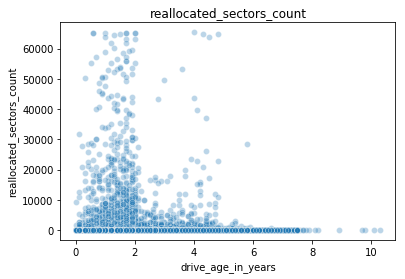

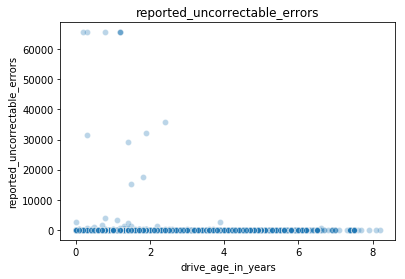

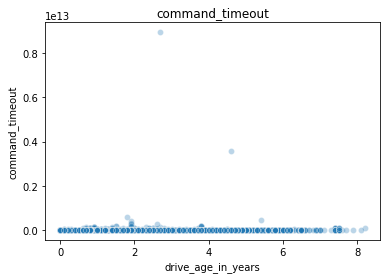

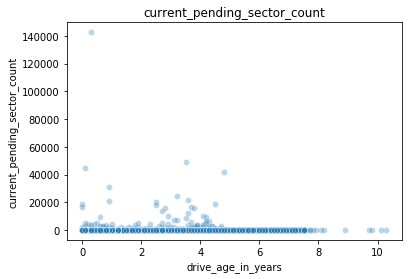

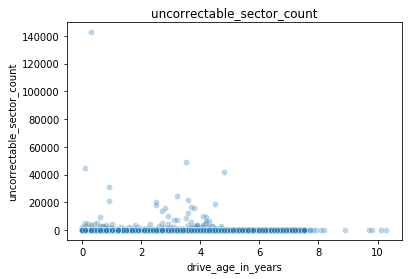

In [12]:
for col in df.columns[6:]:
    sns.scatterplot(data=df, y=df[col], x=df.drive_age_in_years, alpha=.3)
    plt.title(col)
    plt.show()

> It is seen for both "reported_uncorrectable_errors" and "command_timeout" that the vast majority of values are zero. therefore, the nulls in those columns are replaced with zeros. For the remaining nulls in "reallocated_sectors_count", "current_pending_sector_count" and "uncorrecteable_sector_count", there are less than 200 for each respective column. Therefore, those rows containing nulls are removed. This is performed in the `prepare.treat_nulls` function.

In [13]:
df = prepare.treat_nulls(df)

In [14]:
df.isnull().sum()

serial_number                    0
manufacturer                     0
model                            0
capacity_gigabytes               0
failure                          0
drive_age_in_years               0
reallocated_sectors_count        0
reported_uncorrectable_errors    0
command_timeout                  0
current_pending_sector_count     0
uncorrectable_sector_count       0
dtype: int64

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161830 entries, 0 to 169067
Data columns (total 11 columns):
serial_number                    161830 non-null object
manufacturer                     161830 non-null object
model                            161830 non-null object
capacity_gigabytes               161830 non-null float64
failure                          161830 non-null int64
drive_age_in_years               161830 non-null float64
reallocated_sectors_count        161830 non-null float64
reported_uncorrectable_errors    161830 non-null float64
command_timeout                  161830 non-null float64
current_pending_sector_count     161830 non-null float64
uncorrectable_sector_count       161830 non-null float64
dtypes: float64(7), int64(1), object(3)
memory usage: 14.8+ MB


> After treating all nulls, the dataframe has 11 columns and 161,830 rows. The data is ready to be further explored. 

#### How many different models? Which are top 5?

In [16]:
df.model.nunique()

97

In [17]:
df['model'].value_counts().head()

ST12000NM0007           38271
ST4000DM000             36156
HGST HMS5C4040BLE640    16314
ST8000NM0055            14810
HGST HUH721212ALN604    10875
Name: model, dtype: int64

#### How many different manufacturers?

In [18]:
df.manufacturer.nunique()

6

In [19]:
df.manufacturer.unique()

array(['Hitachi', 'Seagate', 'Western Digital', 'Toshiba', 'Unknown',
       'Samsung'], dtype=object)

#### How many different gigabytes sizes?

In [20]:
df.capacity_gigabytes.nunique()

16

In [21]:
df.capacity_gigabytes.unique()

array([ 4001.,  3001.,  8002.,   500.,  6001.,  2000.,  1000.,    80.,
       12000., 10001., 14001.,  1500.,   160.,   320.,   250.,  5001.])

#### How many models are there for each manufacturer?

In [22]:
# create new df to group unique models with their manufacturer
unique_manufacturers = df[['model', 'manufacturer']]

In [23]:
unique_manufacturers.groupby('manufacturer').count()

,model
manufacturer,
Hitachi,51417
Samsung,1
Seagate,105012
Toshiba,2573
Unknown,1
Western Digital,2826


The `explore.remove_manufacturer` function reads in the dataframe and removes the two manufacturers with low value count.

In [24]:
df = explore.remove_manufacturers(df)

#### Are model numbers unique to capacity?

In [25]:
# create new df to group models with their capacity gigabytes
model_gigabytes = df[['model', 'capacity_gigabytes']]

In [26]:
# count unique models
model_gigabytes.model.nunique()

95

In [27]:
# group unique model and unique gigabytes combinations
unique_model_gigabytes = len(model_gigabytes.groupby(['model', 'capacity_gigabytes']).count())

In [28]:
# compare the length of unique model and gigabytes combinations to the count of unique models, must equal a match.
unique_model_gigabytes == model_gigabytes.model.nunique()

True

> The same model number does not have any occurances in the dataframe of having different gigabytes assignments.

#### How do the lifespans of hard drives that have failed compared to hard drives that have not failed?

In [29]:
# create new dfs with hard drives that have failed, and hard drives that have not failed 
df_fails = df [df.failure == 1]
df_lives = df [df.failure == 0]

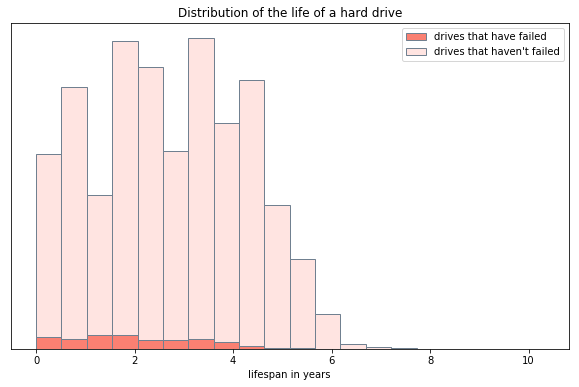

In [30]:
plt.figure(figsize=(10,6))
plt.hist([df_fails.drive_age_in_years, df_lives.drive_age_in_years], stacked=True, bins=20,
         edgecolor='slategrey', color=['salmon', 'mistyrose'])
plt.legend(["drives that have failed","drives that haven't failed"])
plt.title("Distribution of the life of a hard drive")
plt.xlabel("lifespan in years")
plt.yticks([])
plt.show()

#### How do non-zero SMART stat values compare in failed hard drives and non-failed hard drives

In [31]:
# misty

#### Does the average age of drive vary by manufacturer? model number?

In [32]:
# Average drive age by manufacturer
manufacturer_avg_age = df[['manufacturer', 'drive_age_in_years']]
man = manufacturer_avg_age.groupby('manufacturer',sort=True).mean()
man

,drive_age_in_years
manufacturer,
Hitachi,3.057432
Seagate,2.557938
Toshiba,1.611698
Western Digital,3.765322


Text(0.5,1,'Manufacturers by Average Drive Age')

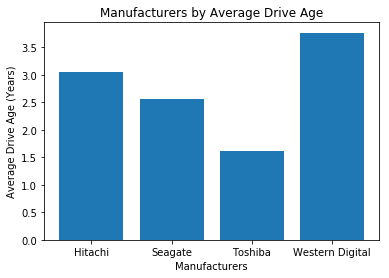

In [33]:
# Plot of Manufacturers by Average Drive Age
ax1 = plt.bar(x= man.index ,height=man.drive_age_in_years)
plt.xlabel('Manufacturers')
plt.ylabel('Average Drive Age (Years)')
plt.title('Manufacturers by Average Drive Age')

In [34]:
# Average drive age by model
model_avg_age = df[['model', 'drive_age_in_years']]
model_avg_age.groupby('model',sort=True).mean().describe()

,drive_age_in_years
count,95.000000
mean,3.510453
std,1.973535
min,0.026316
25%,1.969744
50%,3.600000
75%,4.656250
max,10.300000


Text(0.5,1,'Models by Average Drive Age')

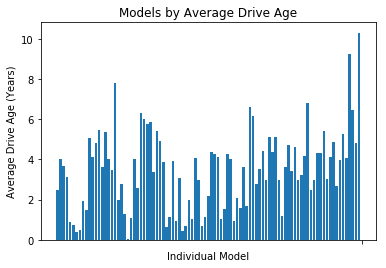

In [35]:
# Plot of Models by Average Drive Age
mod = model_avg_age.groupby('model',sort=True).mean()
# ax2 = plt.scatter(x= mod.index ,y=mod.drive_age_in_years)
ax2 = plt.bar(x= mod.index ,height=mod.drive_age_in_years)
# ax2.axes.get_xaxis().set_ticks([])
plt.xticks('')
plt.xlabel('Individual Model')
plt.ylabel('Average Drive Age (Years)')
plt.title('Models by Average Drive Age')

> Variance in drive age is seen in both the manufacturers and model numbers. 

#### Do failure rates vary by model number?

In [36]:
# aggegrate by failure, drive age, and add a total count
agg_model = df.groupby(['model']).agg({'failure' : 'sum', 'model' : 'count', 'drive_age_in_years':'mean'})
agg_model.rename(columns={'failure':'failures', 'model':'total_count'}, inplace=True)

# add a failure rate column
agg_model['failure_rate_percent'] = agg_model['failures'] / agg_model['total_count'] * 100
agg_model.sort_values(by=['failures'], ascending = False)

,failures,total_count,drive_age_in_years,failure_rate_percent
model,,,,
ST4000DM000,2858,36156,3.874463,7.904635
ST12000NM0007,1104,38271,1.269486,2.884691
ST8000NM0055,383,14810,2.198433,2.586090
ST8000DM002,321,10160,2.982657,3.159449
HGST HMS5C4040BLE640,222,16314,3.121123,1.360794
...,...,...,...,...
ST500LM021,0,33,0.442424,0.000000
WDC WD2500AAJB,0,1,3.600000,0.000000
WDC WD2500AAJS,0,3,4.700000,0.000000


#### Determine early failure cutoff 

The goal of the project is to determine which hard drives are more prone to early failures. Looking at the lifespan of all hard drives, a hard drive that fails within the first quartile of all life spans, is labeled as an early failure.

In [37]:
df[['drive_age_in_years']].describe()

,drive_age_in_years
count,161828.000000
mean,2.722680
std,1.524778
min,0.000000
25%,1.600000
50%,2.600000
75%,4.000000
max,10.300000


> A cut-off of 1.6 years is utilized.

The `explore.early_failure` function creates a column in the dataframe that identifies drives that are early failures.

In [38]:
df = explore.early_failure(df,1.6)

It was deteremined that drives that are currently working and have not reached the established cut-off time will be removed from this analysis, as they are too young to give significant stats of a reliable drive. Therefore, the `explore.old_or_fail` function drops rows containing drives that have not failed and are not older than the cut off.

In [39]:
df = explore.old_or_fail(df,1.6)

In [40]:
df.head()

,serial_number,manufacturer,model,capacity_gigabytes,failure,drive_age_in_years,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count,early_failure
0,PL1311LAG1SJAA,Hitachi,Hitachi HDS5C4040ALE630,4001.0,0,5.0,0.0,0.0,0.0,0.0,0.0,0
1,Z305KB36,Seagate,ST4000DM000,4001.0,0,3.5,0.0,0.0,0.0,0.0,0.0,0
2,MJ0351YNG9MZXA,Hitachi,Hitachi HDS5C3030ALA630,3001.0,0,4.8,0.0,0.0,0.0,0.0,0.0,0
3,ZA11NHSN,Seagate,ST8000DM002,8002.0,0,3.0,0.0,0.0,0.0,0.0,0.0,0
4,MJ1311YNG2ZSEA,Hitachi,Hitachi HDS5C3030ALA630,3001.0,0,5.5,0.0,0.0,0.0,0.0,0.0,0


#### Which SMART attributes correlate most strongly with early failure?

The five SMART stats being presented count the occurrence of different types of errors that can occur in hard drives. For each type a count of above zero indicates that a hard drive should be replaced quickly due to a risk of failure.

In [41]:
smart_stats_5 = df.columns[6:11]
smart_stats_5

Index(['reallocated_sectors_count', 'reported_uncorrectable_errors',
       'command_timeout', 'current_pending_sector_count',
       'uncorrectable_sector_count'],
      dtype='object')

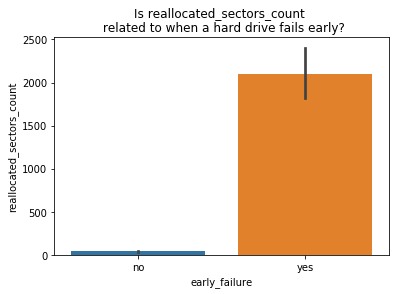

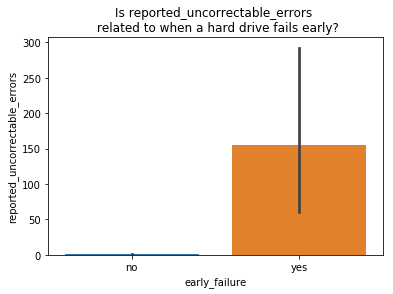

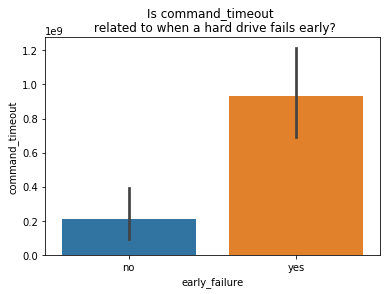

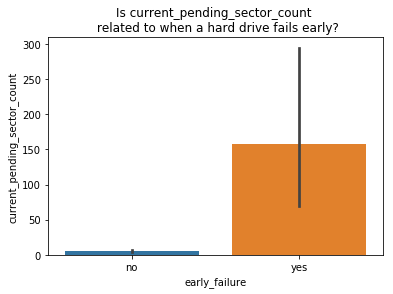

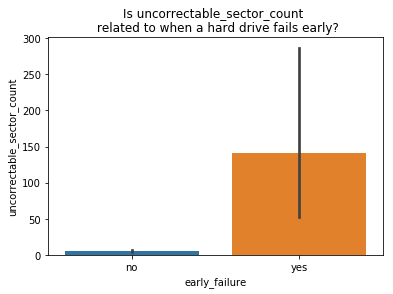

In [42]:
for stat in smart_stats_5:
    sns.barplot(df.early_failure,df[stat])
    plt.title("Is {} \n related to when a hard drive fails early?".format(stat))
    plt.xticks([0,1],["no","yes"])
    plt.show()

> Because these errors occur far more frequently in early failures than in non-early failures, all of these SMART seem to be a good indicator for early failures. 

#### Which features or combination of features correlate with early failure?

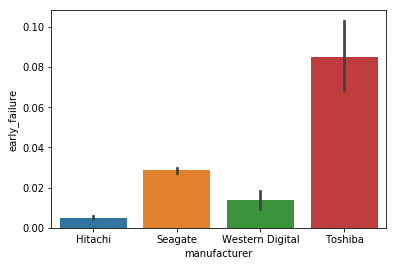

In [43]:
sns.barplot(df.manufacturer,df.early_failure)
plt.show()

> Of the four manufacturers being analyzed, Toshiba produces significantly more early failures.

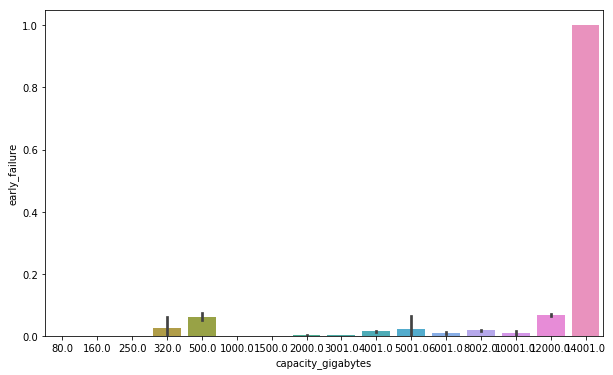

In [44]:
# sns.set(rc={'figure.figsize':(10,6)})
plt.figure(figsize=(10,6))
sns.barplot(df.capacity_gigabytes,df.early_failure)
plt.show()

> Failure rate dramatically increases in drives that have a 14,000 gigabyte capacity.

## Split

In [52]:
X_train, X_test, y_train, y_test = model.split_my_data(df)

In [59]:
X_train.shape

(97520, 10)

In [54]:
X_test.shape

(24380, 10)

In [55]:
y_train.shape

(97520, 1)

In [56]:
y_test.shape

(24380, 1)

## Model